Certainly! Below is an example of a state-of-the-art Variational Autoencoder (VAE) implemented in PyTorch for the CIFAR-10 dataset, which is a non-trivial dataset of 32x32 color images in 10 classes. This implementation includes convolutional layers, which are suitable for image data, and leverages modern deep learning practices.

**Overview:**

- **Dataset:** CIFAR-10
- **Model:** Convolutional Variational Autoencoder (VAE)
- **Framework:** PyTorch
- **Key Features:**
  - Convolutional layers in both encoder and decoder.
  - Reparameterization trick for sampling latent variables.
  - Use of Batch Normalization and LeakyReLU activations.
  - Training loop with monitoring of loss components.



In [10]:
### 1. Import Necessary Libraries


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
### 2. Define Hyperparameters

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
latent_dim = 128

In [3]:
### 3. Prepare the CIFAR-10 Dataset


# Data transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=transform, download=True
)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
### 4. Define the VAE Model


class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 16, 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 8, 8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [B, 128, 4, 4]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),  # [B, 128*4*4]
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),  # [B, 128, 4, 4]
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, stride=2, padding=1
            ),  # [B, 64, 8, 8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                64, 32, kernel_size=4, stride=2, padding=1
            ),  # [B, 32, 16, 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32, 3, kernel_size=4, stride=2, padding=1
            ),  # [B, 3, 32, 32]
            nn.Tanh(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Sample from standard normal
        return mu + eps * std

    def forward(self, x):
        # Encode
        x_encoded = self.encoder(x)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        x_decoded = self.decoder_input(z)
        x_recon = self.decoder(x_decoded)
        return x_recon, mu, logvar

In [5]:
### 5. Define the Loss Function

# The loss function for a VAE includes a reconstruction loss and a Kullback-Leibler divergence term.


def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

In [6]:
### 6. Initialize the Model, Optimizer, and Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
### 7. Training Loop

model.train()
train_losses = []
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 327.5661
Epoch [2/20], Loss: 225.1647
Epoch [3/20], Loss: 210.7678
Epoch [4/20], Loss: 203.9392
Epoch [5/20], Loss: 201.5008
Epoch [6/20], Loss: 199.0534
Epoch [7/20], Loss: 197.2551
Epoch [8/20], Loss: 196.0100
Epoch [9/20], Loss: 194.7954
Epoch [10/20], Loss: 194.0539
Epoch [11/20], Loss: 193.3095
Epoch [12/20], Loss: 192.5937
Epoch [13/20], Loss: 191.7374
Epoch [14/20], Loss: 191.3024
Epoch [15/20], Loss: 190.9245
Epoch [16/20], Loss: 190.3180
Epoch [17/20], Loss: 189.3774
Epoch [18/20], Loss: 189.2539
Epoch [19/20], Loss: 188.6022
Epoch [20/20], Loss: 188.4296


In [8]:
### 8. Visualizing the Results

#### Function to Display Original and Reconstructed Images


def show_reconstructions(model, data_loader):
    model.eval()
    with torch.no_grad():
        data_iter = iter(data_loader)
        images, _ = next(data_iter)
        images = images.to(device)
        recon_images, _, _ = model(images)
        # Move images to CPU and convert to numpy
        images = images.cpu().numpy()
        recon_images = recon_images.cpu().numpy()

        # Display original images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            ax = axes[0, i]
            img = images[i].transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
            ax.imshow(img)
            ax.axis("off")
            ax.set_title("Original")
        # Display reconstructed images
        for i in range(8):
            ax = axes[1, i]
            img = recon_images[i].transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.axis("off")
            ax.set_title("Reconstructed")
        plt.show()

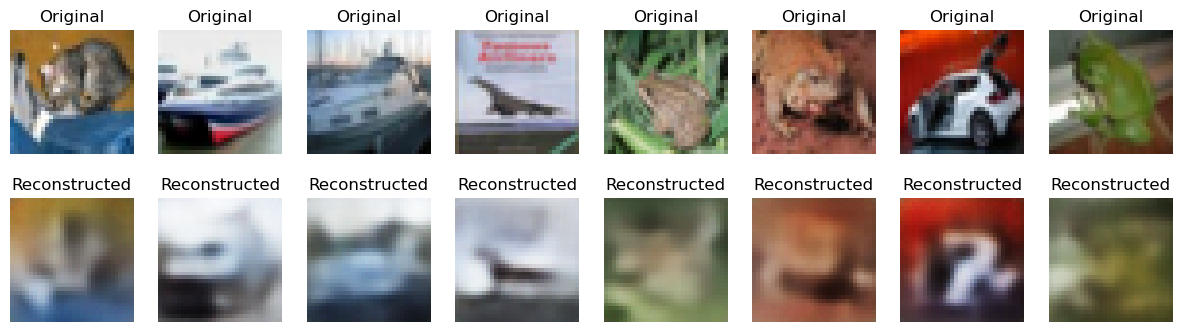

In [11]:
#### Display the Reconstructions

show_reconstructions(model, test_loader)

In [12]:
### 9. Sampling New Images from the Latent Space


def sample_latent_space(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        sample = model.decoder(model.decoder_input(z))
        sample = sample.cpu().numpy()
        # Display generated images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax = axes[i]
            img = sample[i].transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.axis("off")
        plt.show()

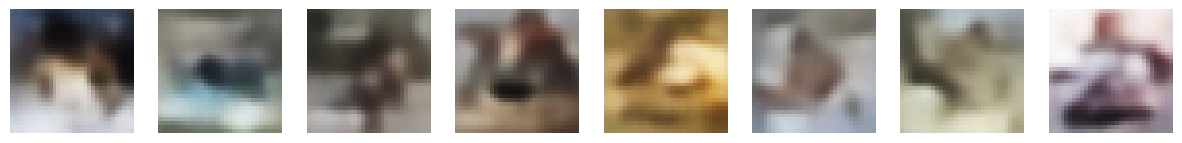

In [13]:
#### Generate and Display New Images

sample_latent_space(model, num_samples=8)

### Explanation:

- **Encoder:** Compresses the image into a latent representation (`mu` and `logvar`).
- **Reparameterization Trick:** Allows backpropagation through stochastic sampling by introducing `eps`.
- **Decoder:** Reconstructs the image from the latent representation.
- **Loss Function:** Combines reconstruction loss and KL divergence to ensure the latent space follows a standard normal distribution.

### Notes:

- **Batch Normalization:** Improves training stability and convergence.
- **LeakyReLU Activation:** Helps prevent dying ReLU problem.
- **Tanh Activation in Output Layer:** To constrain the output pixel values between -1 and 1 (since the input images are normalized accordingly).

### Dependencies:

Ensure you have the necessary packages installed:

```bash
pip install torch torchvision matplotlib
```

### Potential Improvements:

- **Deeper Networks:** Increasing the number of layers might capture more complex representations.
- **Data Augmentation:** Applying random transformations to the input images to improve robustness.
- **Alternative Loss Functions:** Experiment with perceptual losses or adversarial training to enhance image quality.

---

### Conclusion:

This example demonstrates a convolutional variational autoencoder implemented in PyTorch for the CIFAR-10 dataset. The VAE effectively compresses and reconstructs images and allows for sampling of new images from the learned latent space.

# Suggestion for improving performance of the model

I'm sorry to hear that the autoencoder and VAE models are not providing satisfactory reconstructions of the CIFAR-10 images. Reconstructing images from complex datasets like CIFAR-10 can indeed be challenging due to the small image size and high variability in the data. Here are several suggestions and potential modifications you can make to improve the performance of your models:

---

### **1. Increase the Capacity of the Network**

#### **Deepen the Network**

- **Add More Layers**: Introduce additional convolutional layers in both the encoder and decoder to enable the network to learn more complex features.
- **Increase Filter Sizes and Counts**: Use larger filter sizes or increase the number of filters in each convolutional layer.

#### **Example Modification:**

```python
class EnhancedConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [B, 256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # [B, 512, 2, 2]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.Flatten(),  # [B, 512*2*2]
            nn.Linear(512 * 2 * 2, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 2 * 2),
            nn.Unflatten(1, (512, 2, 2)),  # [B, 512, 2, 2]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # [B, 256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # [B, 3, 32, 32]
            nn.Tanh()
        )
```

---

### **2. Increase the Latent Dimension Size**

- **Reasoning**: A larger latent space can capture more information about the input data, which may help in reconstructing images more accurately.
- **Suggestion**: Try increasing the `latent_dim` from 128 to 256 or even 512.

#### **Example:**

```python
latent_dim = 256  # Increased from 128
```

---

### **3. Use Skip Connections (U-Net Architecture)**

- **Reasoning**: Skip connections help in preserving spatial information that may be lost during encoding.
- **Implementation**: Modify the autoencoder to include skip connections between corresponding layers in the encoder and decoder.

#### **Example Modification:**

```python
class UNetAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(UNetAutoencoder, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),  # [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),  # [B, 256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU())
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),  # [B, 512, 2, 2]
            nn.BatchNorm2d(512),
            nn.LeakyReLU())

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512*2*2, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 512*2*2)
        self.unflatten = nn.Unflatten(1, (512, 2, 2))

        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # [B, 256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU())
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(256*2, 128, 4, 2, 1),  # [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(128*2, 64, 4, 2, 1),  # [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(64*2, 3, 4, 2, 1),  # [B, 3, 32, 32]
            nn.Tanh())

    def forward(self, x):
        # Encoder with skip connections
        x1 = self.enc_conv1(x)
        x2 = self.enc_conv2(x1)
        x3 = self.enc_conv3(x2)
        x4 = self.enc_conv4(x3)

        # Bottleneck
        x_flat = self.flatten(x4)
        latent = self.fc1(x_flat)

        # Decoder with skip connections
        x_flat = self.fc2(latent)
        x_unflat = self.unflatten(x_flat)

        y4 = self.dec_conv4(x_unflat)
        y4 = torch.cat([y4, x3], dim=1)  # Skip connection

        y3 = self.dec_conv3(y4)
        y3 = torch.cat([y3, x2], dim=1)  # Skip connection

        y2 = self.dec_conv2(y3)
        y2 = torch.cat([y2, x1], dim=1)  # Skip connection

        output = self.dec_conv1(y2)
        return output
```

- **Note**: Ensure that concatenation along the channel dimension uses matching sizes. Adjust the number of channels accordingly.

---

### **4. Use Different Activation Functions**

- **Reasoning**: The choice of activation function can impact how well the network learns complex patterns.
- **Suggestion**: Try using `ReLU` or `ELU` instead of `LeakyReLU`, as they may provide better performance in certain cases.

#### **Example:**

```python
nn.ReLU()
```

---

### **5. Change the Loss Function**

- **Reasoning**: Mean Squared Error (MSE) tends to produce blurry images because it minimizes the average difference between pixels, which may not capture perceptual differences.
- **Suggestion**: Use **Structural Similarity Index (SSIM)**, **Perceptual Loss**, or **Adversarial Loss** to improve the quality of reconstructed images.

#### **Implementing Perceptual Loss:**

- **Use a Pre-trained Network**: Compute the loss based on features extracted from a pre-trained model like VGG16.

```python
import torchvision.models as models

# Pre-trained VGG16 model for feature extraction
vgg16 = models.vgg16(pretrained=True).features[:16].to(device).eval()

# Loss function
def perceptual_loss(recon_x, x):
    # Compute features
    with torch.no_grad():
        x_features = vgg16(x)
    recon_x_features = vgg16(recon_x)
    # Feature Loss
    loss = nn.functional.mse_loss(recon_x_features, x_features)
    return loss
```

- **Combine with MSE Loss**:

```python
def total_loss(recon_x, x):
    mse = nn.functional.mse_loss(recon_x, x)
    p_loss = perceptual_loss(recon_x, x)
    return mse + 0.1 * p_loss  # Adjust weight as needed
```

---

### **6. Data Augmentation**

- **Reasoning**: Augmenting the data can help the model generalize better and learn more robust features.
- **Suggestion**: Apply random transformations like horizontal flips, rotations, color jittering, etc.

#### **Example:**

```python
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
```

---

### **7. Adjust Training Parameters**

- **Increase the Number of Epochs**: Training for more epochs allows the model to learn more from the data.

```python
num_epochs = 50  # Increased from 20
```

- **Learning Rate Scheduling**: Use a learning rate scheduler to adjust the learning rate during training.

```python
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
```

- **Use a Different Optimizer**: Try using `AdamW` or experiment with the optimizer's parameters.

---

### **8. Batch Normalization Placement and Types**

- **Layer Normalization or Instance Normalization**: These can sometimes perform better than Batch Normalization, especially for certain tasks.

#### **Example:**

```python
nn.InstanceNorm2d(num_features)
```

---

### **9. Regularization Techniques**

- **Dropout Layers**: Add dropout layers to prevent overfitting.

```python
nn.Dropout(p=0.5)
```

---

### **10. Ensure Correct Data Normalization and Denormalization**

- **Double-Check Normalization**: Verify that the normalization parameters match between the data preprocessing and the network's expectations.

- **Denormalization for Visualization**: Ensure that images are correctly denormalized when visualizing to assess reconstruction quality accurately.

---

### **11. Use Higher Resolution Images**

- **Reasoning**: CIFAR-10 images are quite small. Training on higher resolution images can improve perceptual quality.

- **Suggestion**: Use datasets with larger images or upsample CIFAR-10 images (e.g., to 64x64) before feeding them into the network.

---

### **12. Use Advanced Network Architectures**

- **Reasoning**: Modern architectures like ResNets, DenseNets, or attention mechanisms can capture more complex patterns.

- **Suggestion**: Incorporate residual blocks or attention modules into your encoder and decoder.

#### **Example of a Residual Block:**

```python
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return nn.ReLU(inplace=True)(x + self.block(x))
```

---

### **13. Use Denoising Autoencoders**

- **Reasoning**: Training the autoencoder to reconstruct images from noisy inputs can help the model learn more robust features.

- **Suggestion**: Add noise to the input images during training.

#### **Example:**

```python
# In the training loop
noisy_data = data + 0.1 * torch.randn_like(data)
noisy_data = torch.clamp(noisy_data, -1.0, 1.0)
reconstructed = model(noisy_data)
loss = criterion(reconstructed, data)  # Compare to original data
```

---

### **14. Fine-tune Batch Size**

- **Reasoning**: Batch size can impact the learning dynamics. Smaller batches may allow the model to generalize better.

- **Suggestion**: Experiment with different batch sizes like 64, 32, or even 16.

---

### **15. Monitor Training with Validation Set**

- **Reasoning**: Overfitting or underfitting can cause poor reconstructions.

- **Suggestion**: Split the training data to include a validation set and monitor validation loss.

---

### **16. Visualize Feature Maps**

- **Reasoning**: Inspecting activations can provide insights into what the network is learning.

- **Suggestion**: Visualize intermediate feature maps to check if the network is capturing meaningful patterns.

---

### **17. Gradient Clipping**

- **Reasoning**: Prevents exploding gradients which can hamper learning.

- **Suggestion**: Apply gradient clipping during the training step.

```python
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```

---

### **18. Experiment with Weight Initialization**

- **Reasoning**: The initial weights can significantly impact learning.

- **Suggestion**: Use different initialization methods like Xavier (Glorot) or He initialization.

```python
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)

model.apply(weights_init)
```

---

### **19. Use Ensemble Methods**

- **Reasoning**: Combining outputs from multiple models can improve performance.

- **Suggestion**: Train several autoencoders with different initializations and average their outputs.

---

### **20. Change the Dataset**

- **Reasoning**: If the CIFAR-10 dataset is too challenging, consider starting with a simpler dataset like MNIST or Fashion-MNIST to ensure your model works as expected.

---

### **21. Perform Hyperparameter Tuning**

- **Reasoning**: Finding the optimal values for hyperparameters can significantly affect model performance.

- **Suggestion**: Use techniques like Grid Search, Random Search, or Bayesian Optimization.

---

### **22. Use Learning Rate Warm-up and Decay**

- **Reasoning**: Gradually increasing the learning rate at the start can help with optimization.

- **Suggestion**: Implement a warm-up period in your learning rate scheduler.

---

### **Implementation Steps:**

1. **Select a Combination of Modifications:**
   - Start by increasing the network capacity and latent dimension.
   - Introduce skip connections to preserve spatial information.
   - Change the loss function to include perceptual loss.

2. **Update the Model Code:**
   - Modify the class definitions as per the adjustments.

3. **Adjust Training Parameters:**
   - Increase the number of epochs and adjust the learning rate.

4. **Retrain the Model:**
   - Train the updated model and monitor the training and validation losses.

5. **Evaluate and Visualize Results:**
   - Use the visualization functions to assess the quality of reconstructions.
   - Compare the results with previous models to gauge improvement.

---

### **Additional Tips:**

- **Debugging:**
  - If reconstructions are not improving, consider training on a subset of the data to ensure your model can overfit (as a test).
  - Check for any coding errors or issues in data preprocessing.

- **Incremental Changes:**
  - Make one change at a time to isolate its effect on the model's performance.

- **Consult Literature:**
  - Look into research papers on state-of-the-art autoencoders for image datasets similar to CIFAR-10 for inspiration.

---

### **Conclusion:**

Improving the performance of autoencoders on complex datasets like CIFAR-10 often requires experimenting with the network architecture, loss functions, and training strategies. By increasing the network's capacity, using techniques to preserve spatial information, and choosing appropriate loss functions, you can enhance the model's ability to reconstruct images more accurately.

Remember that deep learning models can be sensitive to various factors, so patience and systematic experimentation are key. If you have any further questions or need assistance with specific implementations, feel free to ask!